In [1]:
# set up the api
import tweepy #https://github.com/tweepy/tweepy
import csv
import pandas as pd 
import matplotlib as plt
from IPython.display import Image
import time
import datetime
import numpy as np
from datetime import timedelta

%matplotlib inline

#Twitter API credentials from https://apps.twitter.com/
consumer_key = ""
consumer_secret = ""
access_key = ""
access_secret = ""


#def get_all_tweets(screen_name):
screen_name='AusConservation'
#time difference to GMT - how many hours are you ahead of GMT
timedif=11
#Twitter only allows access to a users most recent 3240 tweets with this method

#authorize twitter, initialize tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

In [2]:
#initialize a list to hold all the tweepy Tweets
alltweets = []	

#make initial request for most recent tweets (200 is the maximum allowed count)
new_tweets = api.user_timeline(screen_name = screen_name,count=200)

#save most recent tweets
alltweets.extend(new_tweets)

#save the id of the oldest tweet less one
oldest = alltweets[-1].id - 1

user = api.get_user(screen_name)
#img=user.profile_image_url
print user.name
print 'Twitter Account: ','@',user.screen_name
print 'Description: ',user.description
print 'Followers: ',user.followers_count
print 'Most Recent Tweet:', user.status.text
print user.statuses_count

ACF
Twitter Account:  @ AusConservation
Description:  For 50 years, the Australian Conservation Foundation has brought together advocates for nature.
Followers:  18552
Most Recent Tweet: ACF holding Premier screening of Naomi Klein's This Change's Everything in Brisbane on Monday October 19 - tix here http://t.co/2BYKqDHXfl
9489


In [3]:
#keep grabbing tweets until there are no tweets left to grab
while len(new_tweets) > 0:
    #print "getting tweets before %s" % (oldest)

    #all subsiquent requests use the max_id param to prevent duplicates
    new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)

    #save most recent tweets
    alltweets.extend(new_tweets)

    #update the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1

    print "...%s tweets downloaded so far" % (len(alltweets))

#transform the tweepy tweets into a 2D array that will populate the csv	
outtweets = [[tweet.id_str, 
              tweet.created_at, 
              tweet.text.encode('ascii', 'ignore'),
              tweet.retweet_count,
              tweet.favorite_count,
              tweet.entities,              
              tweet.user.screen_name] 
             if not (hasattr(tweet, 'retweeted_status')) else 
             [tweet.id_str, 
              tweet.created_at, 
              tweet.text.encode('ascii', 'ignore'),
              tweet.retweet_count,
              tweet.favorite_count,
              tweet.entities,
              tweet.retweeted_status.user.screen_name] for tweet in alltweets]
#write the csv
#with open('%s_tweets.csv' % screen_name, 'wb') as f:
#    writer = csv.writer(f)
#    writer.writerow(["id","created_at","text",'retweet','name'])
#    writer.writerows(outtweets)

pass

...398 tweets downloaded so far
...596 tweets downloaded so far
...765 tweets downloaded so far
...964 tweets downloaded so far
...1164 tweets downloaded so far
...1364 tweets downloaded so far
...1564 tweets downloaded so far
...1760 tweets downloaded so far
...1960 tweets downloaded so far
...2160 tweets downloaded so far
...2360 tweets downloaded so far
...2558 tweets downloaded so far
...2758 tweets downloaded so far
...2957 tweets downloaded so far
...3157 tweets downloaded so far
...3172 tweets downloaded so far
...3172 tweets downloaded so far


In [4]:
# save the tweet to file
df=pd.DataFrame(outtweets,columns=['id',"created_at","text",'retweet','favored','ent','name'])
df['created_at']=df['created_at']+timedelta(hours=timedif)
df=df[df.name==screen_name]
df['url']=df.ent.apply(lambda x: x['urls'][0]['expanded_url'] if len(x['urls'])>0 else None)
df['hashtag']=df.ent.apply(lambda x: '#'+x['hashtags'][0]['text'] if len(x['hashtags'])>0 else None)
df['photo']=df.ent.apply(lambda x: x['media'][0]['media_url'] if ('media' in x.keys()) else None)
df[["created_at","text",'retweet','favored','hashtag','url','photo']].to_csv(screen_name+' tweets'+'.csv',index=False)

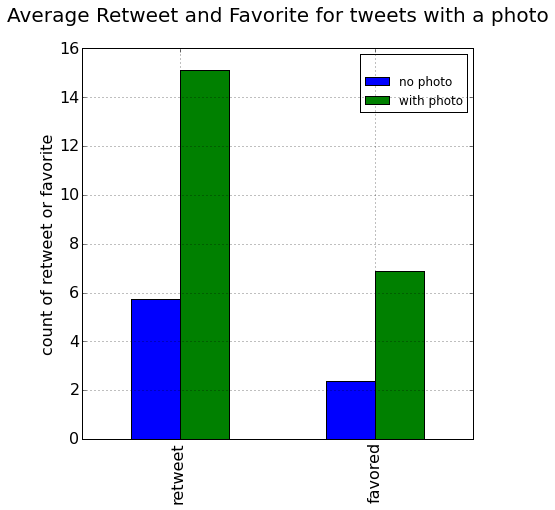

In [5]:
df[' ']=df.photo.apply(lambda x: 'no photo' if (x==None) else 'with photo')
ax=df.groupby(' ').mean().transpose().plot(kind='bar', fontsize=16,figsize=(7,7))
ax.set_xlabel('')
ax.set_ylabel('count of retweet or favorite',fontsize=16)
ax.set_title('Average Retweet and Favorite for tweets with a photo\n',fontsize=20)

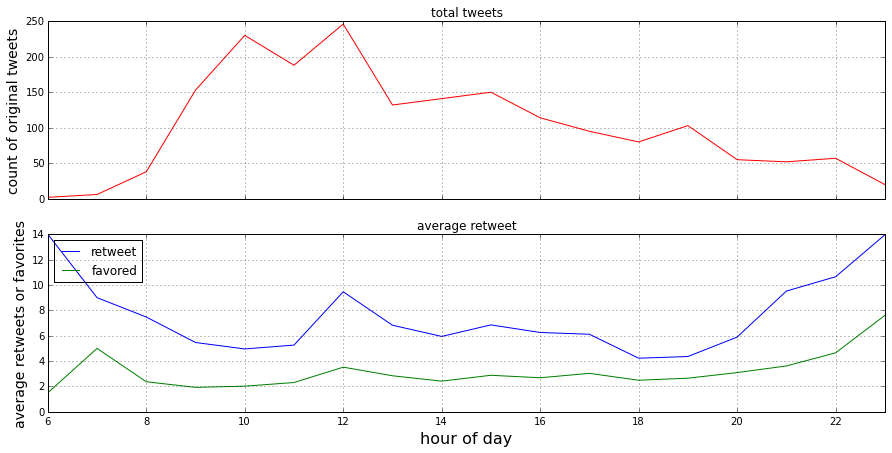

In [6]:
df = df.set_index(pd.to_datetime(df['created_at']))
fig, axes = plt.pyplot.subplots(nrows=2)
axes[1].set_xlabel("hour of day",fontsize=16)
axes[0].set_ylabel('count of original tweets',fontsize=14)
axes[1].set_ylabel('average retweets or favorites',fontsize=14)
df.groupby([df.index.hour])['id'].count().plot(ax=axes[0],figsize=(15,7),color='r',title='total tweets')
df.groupby([df.index.hour]).mean().plot(ax=axes[1],title='average retweet')

In [7]:
d = {'Count' : pd.Series([user.statuses_count, df.shape[0]], index=['All Tweets', 'Original Tweets'])}
print pd.DataFrame(d)

                 Count
All Tweets        9489
Original Tweets   1862


In [8]:
pd.set_option('max_colwidth',130) 
df.sort('retweet',ascending=False).head(20)[['text','retweet','created_at','id']]

,text,retweet,created_at,id
created_at,,,,
2015-05-13 12:07:12,Did you know there's $13bn in #Budget2015 to subsidise mining companies' diesel? ACF's @kellyoshanassy @MattiLRose http://t.co...,195,2015-05-13 12:07:12,598293380511047680
2014-11-15 15:46:42,That backfired! Try as he might @TonyAbbottMHR hasn't been able to keep #climatechange off the #G20Brisbane agenda http://t.co...,142,2014-11-15 15:46:42,533481194046750721
2014-12-22 12:39:38,This morning Tony Abbott proved his views on climate (and women!) are stuck in the 50s. http://t.co/bW7vAewwXA http://t.co/3SK...,139,2014-12-22 12:39:38,546842466247118848
2014-06-21 12:23:34,97% of Australians say our government should protect our World Heritage areas @UNESCO #Doha #MyWorldHeritage http://t.co/XzSym...,114,2014-06-21 12:23:34,480159055541858304
2015-05-18 20:11:01,Burning the lungs of our land isn't renewable. 'Biomass' shouldn't be in the #RET &gt; http://t.co/mZ8VWmlhVc http://t.co/AvPY...,105,2015-05-18 20:11:01,600227077774712832
2014-06-10 16:46:45,"For a guy who insists the world isn't acting on global warming, our PM spends an awful lot of time trying to stop the world ac...",82,2014-06-10 16:46:45,476239022075809792
2014-07-17 13:07:31,"Just to be clear - Australia has no pollution cut targets anymore. It WAS an 80 per cent cut by 2050. Now, nothing.",81,2014-07-17 13:07:31,489592199416262657
2014-07-02 17:06:51,Does a constituent trying to discuss carbon price deserve a better than this? We think so @AndrewLamingMP #auspol http://t.co/...,76,2014-07-02 17:06:51,484216614779244544
2015-03-19 12:26:16,Who are the #biggestpolluters? EXPOSED: 10 big companies polluting air &amp; dissing clean energy http://t.co/dsGwIWxDMb http:...,65,2015-03-19 12:26:16,578366845733896192


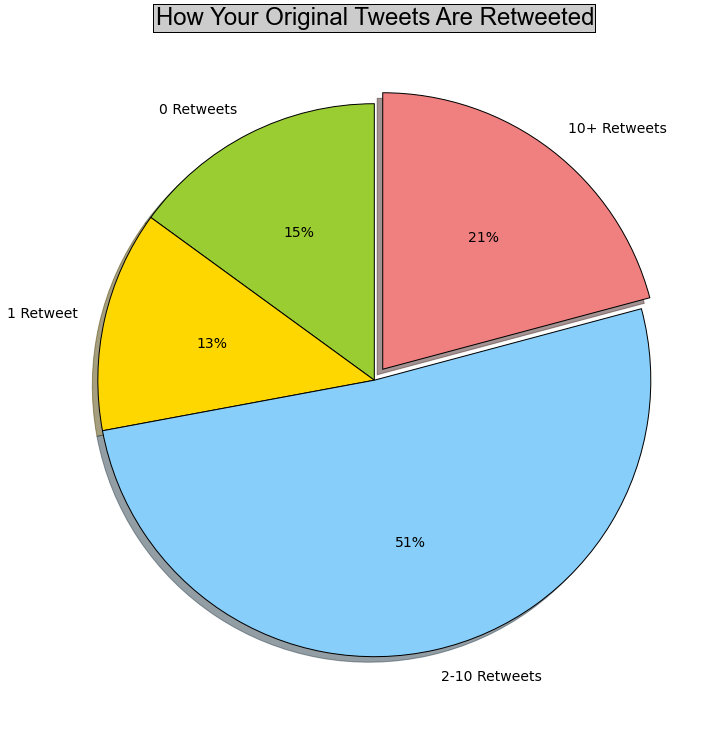

In [9]:
# Distribution of retweets
df.ix[df.retweet==0,'bin']='0 Retweets' 
df.ix[df.retweet==1,'bin']='1 Retweet' 
df.ix[(df.retweet>1) & (df.retweet<10) ,'bin']='2-10 Retweets' 
df.ix[df.retweet>=10,'bin']='10+ Retweets' 
fracs=df.groupby('bin').count().id.reindex(["0 Retweets", "1 Retweet", "2-10 Retweets",'10+ Retweets'])
labels=fracs.index
values=fracs.tolist()
explode=(0, 0, 0, 0.05)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.pyplot.figure(1, figsize=(12,12))
plt.pyplot.ax = plt.pyplot.axes([0.1, 0.1, 0.8, 0.8])
title_font = {'fontname':'Arial', 'size':'24', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
font = {'size'   : 14}
plt.rc('font', **font)

plt.pyplot.pie(values,explode,labels=labels,colors=colors,
    autopct='%1.0f%%', shadow=True, startangle=90)
plt.pyplot.title('How Your Original Tweets Are Retweeted', bbox={'facecolor':'0.8', 'pad':5},**title_font)
plt.pyplot.show()

In [83]:
# download all followers
followers_ids = []
for page in tweepy.Cursor(api.followers_ids, screen_name).pages():
    followers_ids.extend(page)
followers=[]
chunks=[followers_ids[x:x+100] for x in xrange(0,len(followers_ids), 100)]
i=0
for id100 in chunks:
    i=i+1
    try:
        users = api.lookup_users(user_ids=id100)
        followers=followers+[
            [u.name.encode('ascii', 'ignore'), 
             '@'+u.screen_name.encode('ascii', 'ignore'),
             u.followers_count,
             u.friends_count,
             u.location.encode('ascii', 'ignore'),
             'https://twitter.com/'+u.screen_name.encode('ascii', 'ignore')] for u in users]
        if i%10==0 :
            print i*100,'followers downloaded so far'
    except:
        print 'you reached the api call limit! the program will countinou after 15 minutes ...'
        print datetime.datetime.now()
        print ''
        time.sleep(15*60+1)
        users = api.lookup_users(user_ids=id100)
        followers=followers+[
            [u.name.encode('ascii', 'ignore'), 
             '@'+u.screen_name.encode('ascii', 'ignore'),
             u.followers_count,
             u.friends_count,
             u.location.encode('ascii', 'ignore'),
             'https://twitter.com/'+u.screen_name.encode('ascii', 'ignore')] for u in users]
        if i%10==0 :
            print i*100,'followers downloaded so far'
followers_df=pd.DataFrame(followers,columns=('name','twitter','followers','followees','location','link'))
followers_df['ratio']=followers_df.followers/followers_df.followees
followers_df.sort('followers',ascending=False).to_csv(screen_name+' followers'+'.csv',index=False)            

1000 followers downloaded so far
2000 followers downloaded so far
3000 followers downloaded so far
4000 followers downloaded so far
5000 followers downloaded so far
6000 followers downloaded so far
7000 followers downloaded so far
8000 followers downloaded so far
9000 followers downloaded so far
10000 followers downloaded so far
11000 followers downloaded so far
12000 followers downloaded so far
13000 followers downloaded so far
14000 followers downloaded so far
15000 followers downloaded so far
16000 followers downloaded so far
17000 followers downloaded so far
you reached the api call limit! the program will countinou after 15 minutes ...
2015-10-08 15:37:31.282000

18000 followers downloaded so far


In [172]:
followers_df.sort('followers',ascending=False).head(20)

,name,twitter,followers,followees,location,link,ratio,bin
18545,Barack Obama,@BarackObama,64702996,639832,"Washington, DC",https://twitter.com/BarackObama,101.124977,10000+ Followers
15488,UNICEF,@UNICEF,4714963,25115,United Nations,https://twitter.com/UNICEF,187.734939,10000+ Followers
3821,DJ KING ASSASSIN,@DjKingAssassin,4244378,2345810,"Live From Compton, CA",https://twitter.com/DjKingAssassin,1.809344,10000+ Followers
18433,Kevin Rudd,@MrKRudd,1595552,410443,Australia,https://twitter.com/MrKRudd,3.887390,10000+ Followers
3621,NelsonMandela,@NelsonMandela,1186666,23129,"Houghton, South Africa",https://twitter.com/NelsonMandela,51.306412,10000+ Followers
3540,Lil B THE BASEDGOD,@LILBTHEBASEDGOD,1167915,1284233,United States,https://twitter.com/LILBTHEBASEDGOD,0.909426,10000+ Followers
3473,Lord Louis Gilbert,@LordLouis3,993917,564284,,https://twitter.com/LordLouis3,1.761377,10000+ Followers
12093,Jonah Lupton,@JonahLupton,917745,988425,,https://twitter.com/JonahLupton,0.928492,10000+ Followers
18423,@NonprofitOrgs,@nonprofitorgs,803168,259664,"St. Louis, Missouri",https://twitter.com/nonprofitorgs,3.093105,10000+ Followers
16405,Julia Gillard,@JuliaGillard,671614,191322,Australia,https://twitter.com/JuliaGillard,3.510386,10000+ Followers


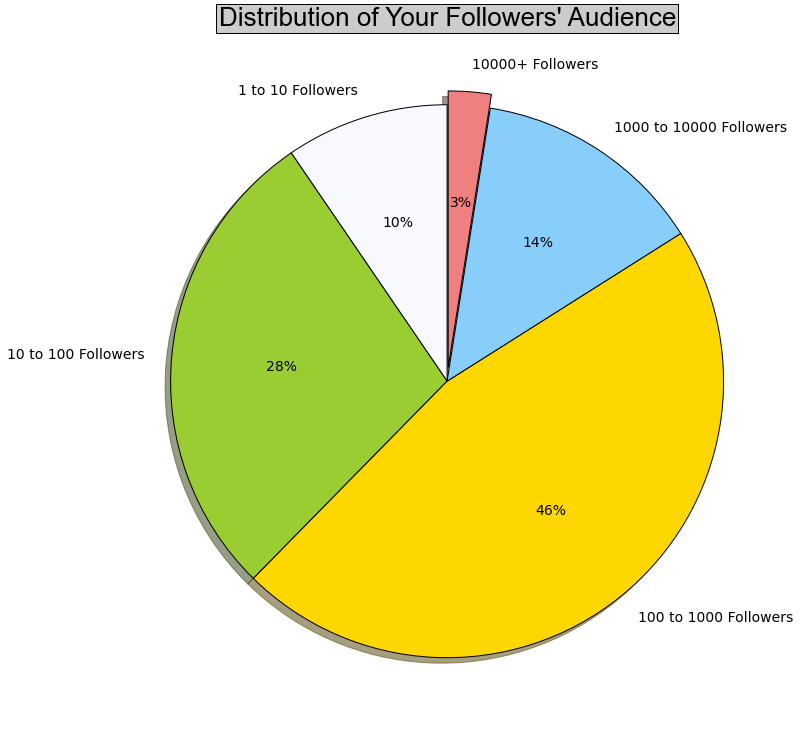

In [161]:
# distribution of followers
followers_df.ix[followers_df.followers<=10,'bin']='1 to 10 Followers' 
followers_df.ix[(followers_df.followers>10) & (followers_df.followers<=100) ,'bin']='10 to 100 Followers' 
followers_df.ix[(followers_df.followers>100) & (followers_df.followers<=1000) ,'bin']='100 to 1000 Followers' 
followers_df.ix[(followers_df.followers>1000) & (followers_df.followers<=10000),'bin']='1000 to 10000 Followers' 
followers_df.ix[followers_df.followers>10000,'bin']='10000+ Followers' 
fracs=followers_df.groupby('bin').count().name
labels=fracs.index
explode=(0, 0, 0, 0, 0.05)
colors = ['GhostWhite','yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.pyplot.figure(1, figsize=(12,12))
plt.pyplot.ax = plt.pyplot.axes([0.1, 0.1, 0.8, 0.8])
title_font = {'fontname':'Arial', 'size':'26', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
font = {'size'   : 14}
plt.rc('font', **font)

plt.pyplot.pie(fracs,explode,labels=labels,colors=colors,
    autopct='%1.0f%%', shadow=True, startangle=90)
plt.pyplot.title('''Distribution of Your Followers' Audience''', bbox={'facecolor':'0.8', 'pad':5},**title_font)
plt.pyplot.show()

In [165]:
#choose a tweet id (from the tweet table) for retweet analysis 
twwet_id='647269951707832320'
rets = api.retweets(twwet_id,100) 

In [166]:
# followers who retweeted
f1=[]
for ret in rets:
    ret_id=ret.user.id
    if ret_id in followers_ids:
        f1=f1+ [ret_id]    
        #print api.lookup_users([str(ret_id)])[0].name
first_order_retweet=[]
for i in f1:
    first_order_retweet=first_order_retweet+ [('@'+screen_name,'@'+api.lookup_users([str(i)])[0].screen_name)]
first_order_retweet

[('AusConservation', u'GumleafG'),
 ('AusConservation', u'toolangi3777'),
 ('AusConservation', u'karenagold'),
 ('AusConservation', u'ActOnClimate'),
 ('AusConservation', u'BluegumPilliga'),
 ('AusConservation', u'HooncheeW'),
 ('AusConservation', u'IIreckon'),
 ('AusConservation', u'suzlette333'),
 ('AusConservation', u'NotKingCoal'),
 ('AusConservation', u'jameswillioms'),
 ('AusConservation', u'barkingowl49'),
 ('AusConservation', u'queen_elizabet'),
 ('AusConservation', u'Jillwrite'),
 ('AusConservation', u'HelenLewers'),
 ('AusConservation', u'rgovett1'),
 ('AusConservation', u'leah_galvin'),
 ('AusConservation', u'Dan_rowe12'),
 ('AusConservation', u'blanketcrap'),
 ('AusConservation', u'JayStill4'),
 ('AusConservation', u'iamsuey'),
 ('AusConservation', u'x4mediaLtd')]

In [168]:
# followers of followers who retweeted

f2=[]
second_order_retweet=[]
for ret in rets:
    ret_id=ret.user.id
    if not (ret_id in followers_ids):
        ret_fscreen_name=ret.user.screen_name
        ret_friends_ids = []
        if ret.user.friends_count<5000:
            try:
                for page in tweepy.Cursor(api.friends_ids, ret_fscreen_name).pages():
                    ret_friends_ids.extend(page)
            except: 
                print 'you reached the api call limit! the program will countinou after 15 minutes ...'
                time.sleep(15*60+1)
                for page in tweepy.Cursor(api.friends_ids, ret_fscreen_name).pages():
                    ret_friends_ids.extend(page)                
            for ret_friend in ret_friends_ids:
                if (ret_friend in f1):
                    print '"@',api.lookup_users([str(ret_friend)])[0].screen_name,'"->"','@',ret.user.screen_name,'";'
                    second_order_retweet=second_order_retweet+[[ '@'+api.lookup_users([str(ret_friend)])[0].screen_name,'@'+ret.user.screen_name]]
                    break

"@ toolangi3777 "->" @ 47ef ";
"@ suzlette333 "->" @ pmlflynn ";
you reached the api call limit! the program will countinou after 15 minutes ...
"@ jameswillioms "->" @ MarekRivers ";
"@ iamsuey "->" @ shamaroo ";
"@ BluegumPilliga "->" @ MinhKular ";
"@ barkingowl49 "->" @ RasataK ";
"@ queen_elizabet "->" @ settlepetal ";
"@ HooncheeW "->" @ DuchessFrida ";
"@ ActOnClimate "->" @ RobbiePHannan ";
"@ GumleafG "->" @ JohnEClements ";
"@ suzlette333 "->" @ VinePsychic ";
you reached the api call limit! the program will countinou after 15 minutes ...
"@ ActOnClimate "->" @ Altraider ";
"@ ActOnClimate "->" @ rubin_angela ";
"@ jameswillioms "->" @ squig_ ";
"@ leah_galvin "->" @ raycaryl ";
"@ toolangi3777 "->" @ caroljd1964 ";
"@ IIreckon "->" @ 53keithm ";


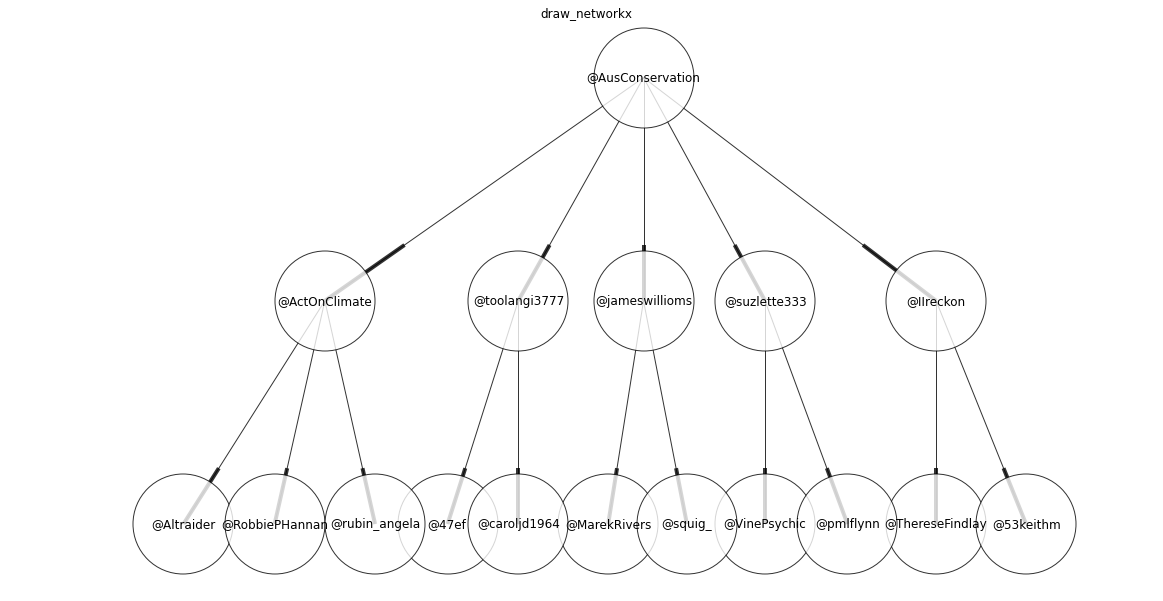

In [173]:
# draw retweet tree (partically)
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

G = nx.DiGraph()

G.add_edges_from([
('@ActOnClimate','@Altraider'),
('@ActOnClimate','@RobbiePHannan'),
('@ActOnClimate','@rubin_angela'),
('@IIreckon','@53keithm'),
('@IIreckon','@ThereseFindlay'),
('@jameswillioms','@MarekRivers'),
('@jameswillioms','@squig_'),
('@suzlette333','@pmlflynn'),
('@suzlette333','@VinePsychic'),
('@toolangi3777','@caroljd1964'),
('@toolangi3777','@47ef'),
('@AusConservation','@toolangi3777'),
('@AusConservation', '@toolangi3777'),
('@AusConservation', '@ActOnClimate'),
('@AusConservation', '@IIreckon'),
('@AusConservation', '@suzlette333'),
('@AusConservation', '@jameswillioms')    
    ])
    
# write dot file to use with graphviz
# run "dot -Tpng test.dot >test.png"
#nx.write_dot(G,'test.dot')

# same layout using matplotlib with no labels
plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title("draw_networkx")
pos=nx.graphviz_layout(G,prog='dot')
nx.draw(G,pos,with_labels=True,arrows=True, node_size=10000,alpha=0.8,node_color='w')